<a href="https://colab.research.google.com/github/Astromax/Reinforcement_Learning_Experiments/blob/main/LunarLander_PolicyExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
The idea here is to test several exploration policies for the LunarLander_v2 environment provided by OpenAI. A full description can be found here https://gym.openai.com/envs/LunarLander-v2/, the environment is considered "solved" with a score of at least 200.0.


In [ ]:
print(f'Commence experiment')

Commence experiment


First we must install some necessary packages.

In [ ]:
!pip3 install box2d
!python -m pip install pyvirtualdisplay

     |████████████████████████████████| 1.3 MB 37.4 MB/s 


In [ ]:
#Main imports
from collections import deque
from collections import namedtuple

import gym

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from pyvirtualdisplay import Display

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [ ]:
#Create the environment
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [ ]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import os & move to appropriate directory
import os
os.chdir('/content/drive/MyDrive/Reinforcement_Learning_experiments')
MAIN_DIR = '/content/drive/MyDrive/Reinforcement_Learning_experiments'

In [ ]:
#Final imports
from qnetworks import BaseQNetwork
from qnetworks import DuelingQNetwork

from replays import ReplayBuffer

## Globals
The next cell initializes the global parameters used for the training loop & the plot generator, as well as setting the device to the GPU if available.

In [ ]:
#Establish globals
EPSILON = 1.0           # Initial value of exploration parameter epsilon
EPS_DECAY = 0.995       # Decay constant for exploration parameter
MAX_TSTEPS = 1000       # Maximum number of time steps per episode
MIN_EPS = 0.01          # Minimum value for exploration parameter
NUM_EPISODES = 2000     # Number of training episodes
SEED = 37               # random seed
WINDOW_SIZE = 100       # window size for moving average

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training Loop
The next cell defines the training loop, which can work with any of the agents tested in this notebook.  It uses an exponentially decaying exploration parameter with a hard minimum, meaning it decays to some particular value then holds steady there for all remaining episodes.  Other options for varying the exploration parameter include linear decay with a minimum and harmonic decay, in which the exploration parameter in episode $i$ is $\frac{1}{i}$, either with or without a floor.

In [ ]:
def train(agent, n_episodes: int=NUM_EPISODES, max_t: int=MAX_TSTEPS, eps_start: float=EPSILON, 
          eps_end: float=MIN_EPS, eps_decay: float=EPS_DECAY):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        #if np.mean(scores_window)>=200.0:
            #print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            #torch.save(agent.qnetwork_primary.state_dict(), 'checkpoint.pth')
            #break
    return scores


##Plot Generator
This function takes the raw scores from the training loop, smoothes them according to the window size, produces an appropriately-labelled plot and saves it for posterity.

In [ ]:
def generate_plot(name: str, mode: str, scores: list, window: int) -> None:
    firstpass = np.where(np.array(scores) > 200.0)[0][0]
    print(f'First pass in Episode: {firstpass}')
    score_series = pd.Series(scores)
    windows = score_series.rolling(window)
    smoothedscores = windows.mean()
    firstave = np.where(np.array(smoothedscores) > 200.0)[0][0]
    print(f'First full pass in Episode: {firstave}')
    maxave = np.max(smoothedscores)
    maxind = smoothedscores.idxmax()
    print(f'Maximum Average Score: {maxave}')
    print(f'Maximum Episode Index: {maxind}')
    
    plt.plot(smoothedscores)
    plt.axvline(x=firstave)
    plt.axhline(y=200.0)
    plt.title(f'{name} with {mode} Experience Replay Average Scores')
    plt.xlabel('Episode')
    plt.ylabel(f'Average Score over {window} Episodes')
    plt.savefig(f'{name}_{mode}_Averages.png')
    return


In [ ]:
#Establish hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 4        # how often to update the network

In [ ]:
basehypers = {'BATCH_SIZE': BATCH_SIZE, 'BUFFER_SIZE': BUFFER_SIZE, 
              'GAMMA': GAMMA, 'LR': LR, 'TAU': TAU, 'UPDATE_EVERY': UPDATE_EVERY}

## $\epsilon$-Greedy Policy
This is the usual policy used in early Reinforcement Learning courses, for both tabular systems & those which require neural network function approximators.  With probability $1 - ϵ$ the agent chooses the action that has the greatest value given it's state, whereas with probability $ϵ$ it chooses an action uniformly at random, including potentially that same most-valuable action.  The idea is to trade off exploration & exploitation, starting with an initially large exploration parameter & reducing it as more episodes accumulate and estimates of the true action-values become more certain.

In [ ]:
class EpsilonGreedyAgent:
    def __init__(self, state_size: int, action_size: int, seed: int, hypers: dict, device: torch.device):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed

        self.batch_size    = hypers['BATCH_SIZE']
        self.buffer_size   = hypers['BUFFER_SIZE']
        self.gamma         = hypers['GAMMA']
        self.learning_rate = hypers['LR']
        self.tau           = hypers['TAU']
        self.update_every  = hypers['UPDATE_EVERY']

        self.device = device
        
        #Qnetworks: primary, target, and optimizer
        self.qnetwork_primary = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_primary.parameters(), lr=self.learning_rate)
        
        #Replay buffer
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed, device)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state: np.array, action: int, reward: float, next_state: np.array, done: bool) -> None:
        #Add to the memory buffer
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def act(self, state: np.array, eps: float) -> int:
        """Returns actions for given state as per current policy"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_primary.eval()
        with torch.no_grad():
            action_values = self.qnetwork_primary(state)
        self.qnetwork_primary.train()
        
        #Epsilon-greedy action selection 
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        return random.choice(np.arange(self.action_size))

    def learn(self, experiences: tuple) -> None:
        """The core of the algorithm, the actual updating of the network parameters"""
        states, actions, rewards, next_states, dones = experiences
    
        #Select next state actions using the *primary* network
        argmax_a_q_sp = self.qnetwork_primary(next_states).max(1)[1]
        #Get the next state action values using the *target* network
        q_sp = self.qnetwork_target(next_states).detach()
        #Index the q-values of the target network using the indices chosen by the primary,
        #so: primary network chooses action, target network evaluates action --> DDQN
        max_a_q_sp = q_sp[np.arange(self.batch_size), argmax_a_q_sp].unsqueeze(1) * (1 - dones)
        #Compute the target values
        target_q_sa = rewards + self.gamma * max_a_q_sp
        #Get the actual action values
        q_sa = self.qnetwork_primary(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(q_sa, target_q_sa)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # ------------------- update target network ------------------- #
        self.soft_update()

    def soft_update(self) -> None:
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_primary.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

In [ ]:
EGAgent = EpsilonGreedyAgent(state_size=8, action_size=4, seed=SEED, hypers=basehypers, device=device)

In [ ]:
EGscores = train(EGAgent)

First pass in Episode: 389
First full pass in Episode: 583
Maximum Average Score: 263.32158401770937
Maximum Episode Index: 1618


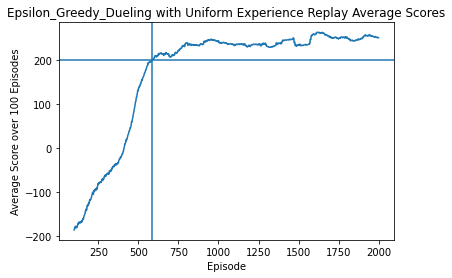

In [ ]:
generate_plot('Epsilon_Greedy_Dueling', 'Uniform', EGscores, WINDOW_SIZE)

In [ ]:
torch.save(EGAgent.qnetwork_primary.state_dict(), f'{MAIN_DIR}/EpsilonGreedyDueling_2000eps_checkpoint.pth')

## Softmax Greedy Policy
This is a variant of the $ϵ$-greedy policy where with probability $ϵ$ the agent chooses an action according to a softmax distribution over the available actions.  This way, even when exploring the agent still uses the information it has already gathered about the environment to make a decision.  In this way, it is inherently more conservative than regular $ϵ$-greedy, because the peak action has an even higher overall chance of being chosen. 

In [ ]:
class SoftmaxGreedyAgent:
    def __init__(self, state_size: int, action_size: int, seed: int, hypers: dict, device: torch.device):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed

        self.batch_size    = hypers['BATCH_SIZE']
        self.buffer_size   = hypers['BUFFER_SIZE']
        self.gamma         = hypers['GAMMA']
        self.learning_rate = hypers['LR']
        self.tau           = hypers['TAU']
        self.update_every  = hypers['UPDATE_EVERY']

        self.device = device
        
        #Primary & Target QNetworks and Optimizer
        self.qnetwork_primary = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_primary.parameters(), lr=self.learning_rate)
        
        #Replay buffer
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed, device)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state: np.array, action: int, reward: float, next_state: np.array, done: bool) -> None:
        #Add to the memory buffer
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def act(self, state: np.array, eps: float) -> int:
        """Returns actions for given state as per current policy"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_primary.eval()
        with torch.no_grad():
            action_values = self.qnetwork_primary(state)
        self.qnetwork_primary.train()

        #Softmax-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        
        probs = F.softmax(action_values, dim=1)
        probs = probs.squeeze().detach().cpu().numpy()
        sel = np.random.choice(self.action_size, size = 1, p = probs)
        sel = sel[0]
        return sel


    def learn(self, experiences: tuple) -> None:
        """The core of the algorithm, the actual updating of the network parameters"""
        states, actions, rewards, next_states, dones = experiences
    
        #Select next state actions using the *primary* network
        argmax_a_q_sp = self.qnetwork_primary(next_states).max(1)[1]
        #Get the next state action values using the *target* network
        q_sp = self.qnetwork_target(next_states).detach()
        #Index the q-values of the target network using the indices chosen by the primary,
        #so: primary network chooses action, target network evaluates action --> DDQN
        max_a_q_sp = q_sp[np.arange(self.batch_size), argmax_a_q_sp].unsqueeze(1) * (1 - dones)
        #Compute the target values
        target_q_sa = rewards + self.gamma * max_a_q_sp
        #Get the actual action values
        q_sa = self.qnetwork_primary(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(q_sa, target_q_sa)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update()


    def soft_update(self) -> None:
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_primary.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

In [ ]:
SGAgent = SoftmaxGreedyAgent(state_size=8, action_size=4, seed=SEED, hypers=basehypers, device=device)

In [ ]:
SGscores = train(SGAgent)

Episode 100	Average Score: -194.12
Episode 200	Average Score: -101.27
Episode 300	Average Score: -29.84
Episode 400	Average Score: 60.27
Episode 500	Average Score: 143.97
Episode 600	Average Score: 170.81
Episode 700	Average Score: 215.41
Episode 800	Average Score: 219.59
Episode 900	Average Score: 224.44
Episode 1000	Average Score: 152.30
Episode 1100	Average Score: 240.69
Episode 1200	Average Score: 201.32
Episode 1300	Average Score: 213.34
Episode 1400	Average Score: 230.29
Episode 1500	Average Score: 245.23
Episode 1600	Average Score: 247.45
Episode 1700	Average Score: 255.54
Episode 1800	Average Score: 256.16
Episode 1900	Average Score: 247.08
Episode 2000	Average Score: 241.55


First pass in Episode: 177
First full pass in Episode: 652
Maximum Average Score: 258.65604558797736
Maximum Episode Index: 1744


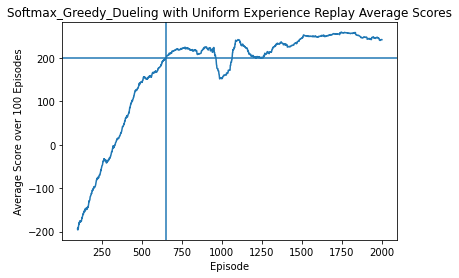

In [ ]:
generate_plot('Softmax_Greedy_Dueling', 'Uniform', SGscores, WINDOW_SIZE)

In [ ]:
torch.save(SGAgent.qnetwork_primary.state_dict(), f'{MAIN_DIR}/SoftmaxGreedyDueling_2000eps_checkpoint.pth')

## Softmax K1 Agent
This agent is nearly identical to the Softmax-Greedy Agent, but with one crucial difference: with probability $ϵ$ it assumes that it is *dead wrong* about the highest-value action, and instead chooses one of the other actions with probability corresponding to their relative values.  This Agent is more adventurous than either Softmax-Greedy or $ϵ$-Greedy, in the sense that it is strictly less likely to choose the highest-value action for a given value of the exploration parameter $ϵ$. The name comes from "Softmax after Killing the #1 Action, otherwise Greedy".

In [ ]:
a = torch.tensor([0.2, 0.8, 0.1, -0.3])
arg = np.argmax(a.numpy())
print('a: ', a)
print('arg: ', arg)
soft = F.softmax(a)
print('soft: ', soft)
a[arg] = float('-inf')
print('modified a: ', a)
modsoft = F.softmax(a)
print('modsoft: ', modsoft)

a:  tensor([ 0.2000,  0.8000,  0.1000, -0.3000])
arg:  1
soft:  tensor([0.2308, 0.4205, 0.2088, 0.1400])
modified a:  tensor([ 0.2000,    -inf,  0.1000, -0.3000])
modsoft:  tensor([0.3982, 0.0000, 0.3603, 0.2415])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [ ]:
class SoftmaxK1Agent:
    def __init__(self, state_size: int, action_size: int, seed: int, hypers: dict, device: torch.device):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed

        self.batch_size    = hypers['BATCH_SIZE']
        self.buffer_size   = hypers['BUFFER_SIZE']
        self.gamma         = hypers['GAMMA']
        self.learning_rate = hypers['LR']
        self.tau           = hypers['TAU']
        self.update_every  = hypers['UPDATE_EVERY']

        self.device = device
        
        #Primary & Target QNetworks and Optimizer
        self.qnetwork_primary = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_primary.parameters(), lr=self.learning_rate)
        
        #Replay buffer
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed, device)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state: np.array, action: int, reward: float, next_state: np.array, done: bool) -> None:
        #Add to the memory buffer
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def act(self, state: np.array, eps: float) -> int:
        """Returns actions for given state as per current policy"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_primary.eval()
        with torch.no_grad():
            action_values = self.qnetwork_primary(state)
        self.qnetwork_primary.train()

        #Softmax-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())

        #print('action_values: ', action_values)
        argmax_q = np.argmax(action_values.cpu().data.numpy())           #Identify the biggest value
        #print(f'argmax_q: {argmax_q}')
        action_values[0][argmax_q] = float('-inf')                          #Set the biggest value to negative infinity
        probs = F.softmax(action_values, dim=1)                          #Compute softmax values
        probs = probs.squeeze().detach().cpu().numpy()                 
        sel = np.random.choice(self.action_size, size = 1, p = probs)    #Select action, ordinarily peak value will NOT be selected
        sel = sel[0]
        return sel
        

    def learn(self, experiences: tuple) -> None:
        """The core of the algorithm, the actual updating of the network parameters"""
        states, actions, rewards, next_states, dones = experiences
    
        #Select next state actions using the *primary* network
        argmax_a_q_sp = self.qnetwork_primary(next_states).max(1)[1]
        #Get the next state action values using the *target* network
        q_sp = self.qnetwork_target(next_states).detach()
        #Index the q-values of the target network using the indices chosen by the primary,
        #so: primary network chooses action, target network evaluates action --> DDQN
        max_a_q_sp = q_sp[np.arange(self.batch_size), argmax_a_q_sp].unsqueeze(1) * (1 - dones)
        #Compute the target values
        target_q_sa = rewards + self.gamma * max_a_q_sp
        #Get the actual action values
        q_sa = self.qnetwork_primary(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(q_sa, target_q_sa)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update()


    def soft_update(self) -> None:
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_primary.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

In [ ]:
SK1Agent = SoftmaxK1Agent(state_size=8, action_size=4, seed=SEED, hypers=basehypers, device=device)

In [ ]:
SK1scores = train(SK1Agent)

Episode 100	Average Score: -160.00
Episode 200	Average Score: -112.76
Episode 300	Average Score: -29.44
Episode 400	Average Score: 69.65
Episode 500	Average Score: 182.11
Episode 600	Average Score: 213.98
Episode 700	Average Score: 206.26
Episode 800	Average Score: 216.86
Episode 900	Average Score: 215.06
Episode 1000	Average Score: 223.36
Episode 1100	Average Score: 220.00
Episode 1200	Average Score: 254.17
Episode 1300	Average Score: 243.31
Episode 1400	Average Score: 181.88
Episode 1500	Average Score: 202.53
Episode 1600	Average Score: 217.63
Episode 1700	Average Score: 235.15
Episode 1800	Average Score: 239.40
Episode 1900	Average Score: 246.03
Episode 2000	Average Score: 248.46


First pass in Episode: 319
First full pass in Episode: 551
Maximum Average Score: 254.57870938091645
Maximum Episode Index: 1193


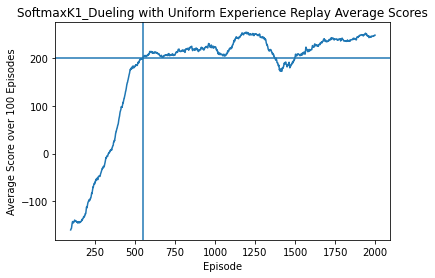

In [ ]:
generate_plot('SoftmaxK1_Dueling', 'Uniform', SK1scores, WINDOW_SIZE)

In [ ]:
torch.save(SK1Agent.qnetwork_primary.state_dict(), f'{MAIN_DIR}/SoftmaxK1Dueling_2000eps_checkpoint.pth')